In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Single Position Signal Trading Simulation System

## Overview of libraries

The code below is meant to give an impression of the current implementation of the libraries that are customly developed for the algorithmic trading algorithm.

### Imports

In [2]:
import poloniex as plnx
import ta_lib as ta
from datetime import datetime, timedelta
from matplotlib.finance import candlestick2_ohlc

### Chart settings

In [3]:
pair = 'USDT_BTC'
timeframe = 30*60
end = datetime.utcnow()
start = end - timedelta(days=4)

In [4]:
chart = plnx.get_chart(pair, timeframe, start, end)

### Technical indicators

In [5]:
ta.daily_returns(chart)
ta.ema(chart)    # default n=7
ta.ema(chart, 23)
ta.bbands(chart) # default n=20
ta.rsi(chart)    # default n=14

### Plotting

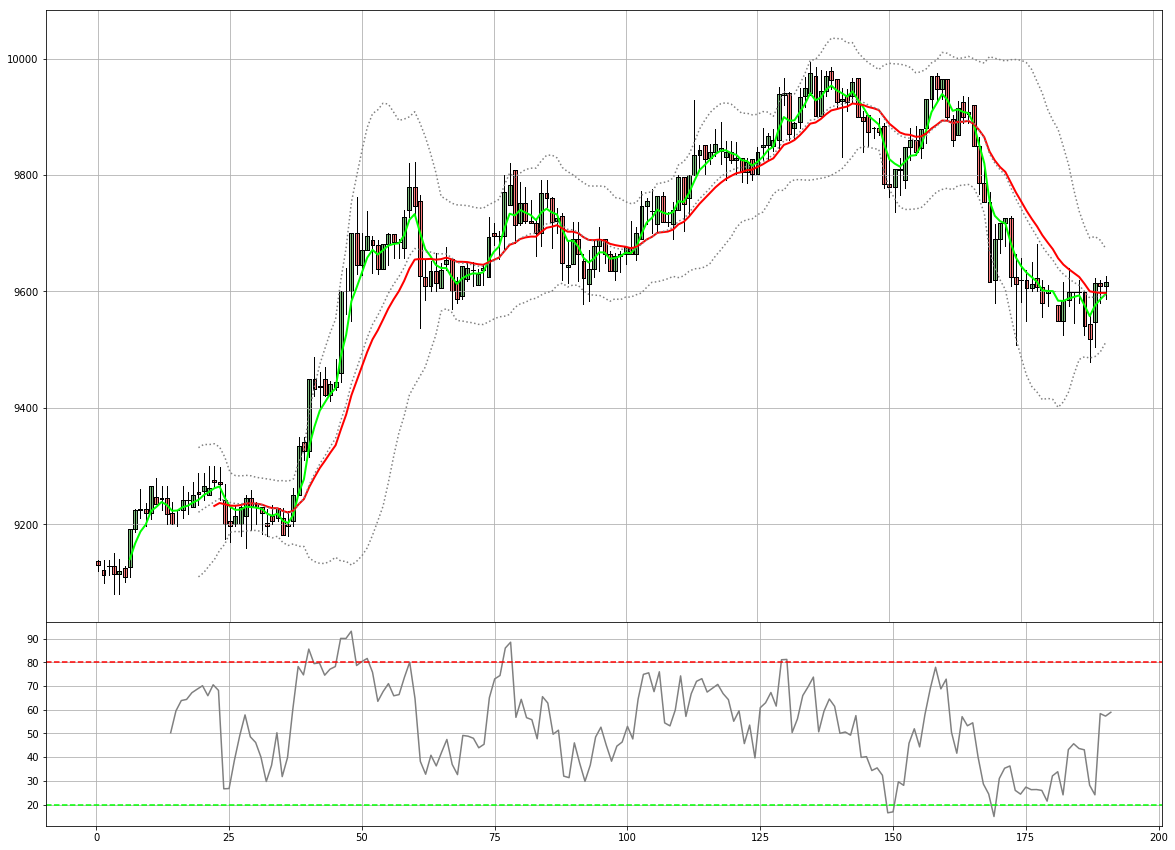

In [6]:
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
f = plt.figure(figsize=(20,15))
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
candlestick2_ohlc(ax1, chart['open'], chart['high'], chart['low'], chart['close'], width=0.74, colorup='g', colordown='r', alpha=0.5)
ax1.plot(chart['ema7'], c='lime', lw=2)
ax1.plot(chart['ema23'], c='red', lw=2)
ax1.plot(chart['bb_mid'], c='gray', ls='dotted')
ax1.plot(chart['bb_upper'], c='gray', ls='dotted')
ax1.plot(chart['bb_lower'], c='gray', ls='dotted')
ax1.grid()
ax2.plot(list(chart.index), chart['rsi'], c='gray')
ax2.grid()
ax2.axhline(y=80, c='red', ls='dashed')
ax2.axhline(y=20, c='lime', ls='dashed')
ax2.fill_between(list(chart.index), 20, 80, color='grey', alpha=0) # 'kinda' corrects the x-axis for RSI 
f.subplots_adjust(hspace=0)

### Data columns

In [7]:
chart.columns

Index(['close', 'date', 'high', 'low', 'open', 'daily_return', 'ema7', 'ema23',
       'bb_mid', 'bb_upper', 'bb_lower', 'rsi'],
      dtype='object')

### Dataset

In [8]:
chart[20:25]

,close,date,high,low,open,daily_return,ema7,ema23,bb_mid,bb_upper,bb_lower,rsi
20,9265.510803,2018-05-03 05:30:00,9287.800000,9241.000000,9257.556000,13.510803,9250.003999,NaN,9226.955439,9337.113923,9116.796955,70.128888
21,9262.844436,2018-05-03 06:00:00,9300.018665,9250.000002,9250.000002,-2.666367,9255.552462,NaN,9232.622096,9336.804070,9128.440122,65.926997
22,9272.613078,2018-05-03 06:30:00,9300.812061,9262.000000,9275.222217,9.768642,9261.837973,9231.426683,9238.621867,9338.295172,9138.948562,70.532035
23,9269.733389,2018-05-03 07:00:00,9298.000000,9241.134121,9272.800000,-2.879689,9264.933454,9236.470375,9243.888584,9332.766026,9155.011142,68.173426
24,9200.000000,2018-05-03 07:30:00,9268.955565,9174.090590,9241.822420,-69.733389,9245.283741,9234.370844,9240.612283,9315.322489,9165.902076,26.666118


## Specification

Specifications for the trading simulator.

### Simulation parameters

We want to be able to adjust the following parameters for the simulation:

1. Symbol 
2. Timeframe
3. Stop loss strategy: `none`, `limit`, `trail`
4. Stop loss percentage (max losses before the trade is stopped out)
5. Amount of leverage used
6. Fee percentage per order
7. Initial balance
8. Lot sizing
9. Signals, when to go long and short

### Simulation metrics

We want to able to track the following metrics:

1. Total trades
2. Winning trades
3. Losing trades
4. Win/loss ratio
5. Trades stopped out
6. Fee paid
7. Fee paid (cumulative)
8. Gains
9. Gains (cumulative)
10. Drawdown
11. Max drawdown
12. Risk/reward ratio 
13. Risk/reward average

### Simulation types

We want to support the following simulation types:

1. Single simulation
2. Multiple simulations for parameter tuning

## Implementation

### Signals

The generated signals are appended to the chart dataset. There will be four columns:

    1. `open_long`
    2. `close_long`
    3. `open_short`
    4. `close_short`
    
A value is $0$ if the signal is off and $1$ if the signal is on.

In [9]:
chart['open_long'] = chart['close_long'] = chart['open_short'] = chart['close_short'] = 0

In [10]:
chart.head(1)

,close,date,high,low,open,daily_return,ema7,ema23,bb_mid,bb_upper,bb_lower,rsi,open_long,close_long,open_short,close_short
0,9129.774819,2018-05-02 19:30:00,9138.540433,9119.0,9136.909928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [11]:
chart.loc[30, 'open_long'] = 1
chart.loc[35, 'close_long'] = 1
chart.loc[100, 'open_short'] = 1
chart.loc[150, 'open_long'] = 1
chart.loc[170, 'close_long'] = 1

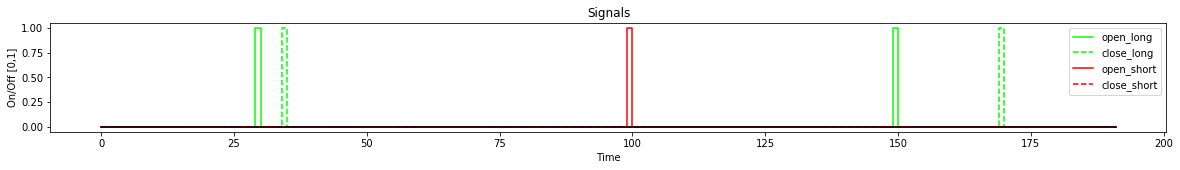

In [12]:
plt.figure(figsize=(20,2))
step(list(chart.index), chart['open_long'], color='lime')
step(list(chart.index), chart['close_long'], color='lime', linestyle='dashed')
step(list(chart.index), chart['open_short'], color='red')
step(list(chart.index), chart['close_short'], color='red', linestyle='dashed')
step(list(chart.index), np.zeros(len(chart.index)), color='black')
plt.title('Signals')
plt.ylabel('On/Off [0,1]')
plt.xlabel('Time')
plt.legend(['open_long', 'close_long', 'open_short', 'close_short']);

Perhaps let `close_long` and `close_short` indicate when we want to reduce a position. The interval used will be $[0,1]$ where $0.5$ will reduce the position by half, and $0.25$ by a quarter. 

Example: we have a position of $1000$. If we want close this position by reducing with four orders, thus reduce $250$ each time, we calculate them as follows:

 1. `0.25 * order_size` for the first order to sell a quarter.
 2. `0.33.. * order_size` for the next quarter (taking into account that the `order_size` has became smaller, but we still want to sell the same position size.)
 3. `0.5 * order_size` for the third quarter.
 4. `1.0 * order_size` for the last quarter.

In [13]:
chart.loc[35, 'close_long'] = 0.25
chart.loc[40, 'close_long'] = 1/3
chart.loc[45, 'close_long'] = 0.50
chart.loc[50, 'close_long'] = 1

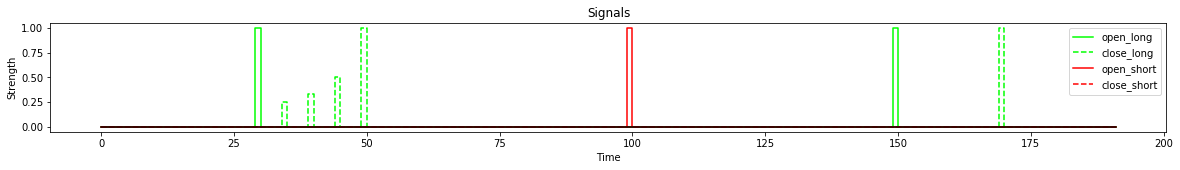

In [14]:
plt.figure(figsize=(20,2))
step(list(chart.index), chart['open_long'], color='lime')
step(list(chart.index), chart['close_long'], color='lime', linestyle='dashed')
step(list(chart.index), chart['open_short'], color='red')
step(list(chart.index), chart['close_short'], color='red', linestyle='dashed')
step(list(chart.index), np.zeros(len(chart.index)), color='black')
plt.title('Signals')
plt.ylabel('Strength')
plt.xlabel('Time')
plt.legend(['open_long', 'close_long', 'open_short', 'close_short']);

In [15]:
chart['open_long'] = chart['close_long'] = chart['open_short'] = chart['close_short'] = 0

In [16]:
class Signals():
    def moving_average_crossover(df, ma_low, ma_high):
        for i in range(1, len(df)):
            previous = df.iloc[i-1]
            current = df.iloc[i]
            
            if np.isnan(previous[ma_low]) or np.isnan(previous[ma_high]) \
               or np.isnan(current[ma_low]) or np.isnan(current[ma_high]): continue
            
            ma_prev = previous[ma_low] - previous[ma_high]
            ma_current = current[ma_low] - current[ma_high]
            
            if ma_prev > 0 and ma_current < 0: df.loc[i, 'open_short'] = 1
            if ma_prev < 0 and ma_current > 0: df.loc[i, 'open_long'] = 1
    
    def init(df):
        df['open_long'] = df['close_long'] = df['open_short'] = df['close_short'] = 0

In [17]:
Signals.moving_average_crossover(chart, 'ema7', 'ema23')

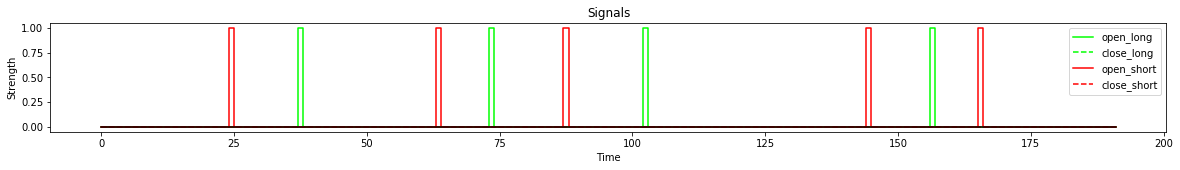

In [18]:
plt.figure(figsize=(20,2))
step(list(chart.index), chart['open_long'], color='lime')
step(list(chart.index), chart['close_long'], color='lime', linestyle='dashed')
step(list(chart.index), chart['open_short'], color='red')
step(list(chart.index), chart['close_short'], color='red', linestyle='dashed')
step(list(chart.index), np.zeros(len(chart.index)), color='black')
plt.title('Signals')
plt.ylabel('Strength')
plt.xlabel('Time')
plt.legend(['open_long', 'close_long', 'open_short', 'close_short']);

### Trade

We want a `Trade` instance that keeps track of:

 * State (`open`, `closed`, `stopped`, `submitted`, `timed_out`, `expired`)
 * Expiry time, if an order expires we want to resubmit a limit order for a new price.
 * Lot size
 * Entry price
 * Exit price
 * P/L
 * P/L in %
 * Stop loss type (`none`, `limit`, `trail`)
 * Stop loss percentage
 * Stop loss price
 * Fees
 * Leverage
 * Net result (P/L adjusted with fees)
 * Entry date
 * Exit date
 * Trade open (hours)

In [19]:
class Trade():
    exit_price = None      # Price when the trade was closed.
    stop_loss_price = None # Price when the stop loss should trigger.
    
    """ Initialize a new order. """
    def __init__(self, position_type, lot_size, leverage, entry_price, stop_loss, stop_loss_percentage, fee_percentage):
        self.state = 'open'
        self.position_type = position_type
        self.lot_size_base = lot_size
        self.lot_size_base_leveraged = lot_size * leverage
        self.lot_size_quote = lot_size / entry_price
        self.lot_size_quote_leveraged = lot_size / entry_price * leverage
        self.leverage = leverage
        self.entry_price = entry_price
        self.stop_loss = stop_loss
        self.stop_loss_percentage = stop_loss_percentage
        self.fee_percentage = fee_percentage
        self.stop_loss_price = (1 - stop_loss_percentage) * entry_price if position_type == 'long' \
                          else (1 + stop_loss_percentage) * entry_price # is short
    
    """ Returns the total order cost in the base currency. """
    def order_cost(self):
        return self.lot_size_base * self.leverage
    
    """ Returns the market value of the order in the base currency. """
    def market_value(self):
        x = self.exit_price if self.exit_price != None else self.current_price
        return self.lot_size_quote * x * self.leverage
    
    """ Returns the P/L for this in the base currency. """
    def pl(self):
        x = self.exit_price if self.exit_price != None else self.current_price
        if self.position_type == 'long':  return self.market_value() - self.order_cost()
        if self.position_type == 'short': return self.order_cost() - self.market_value()
                                         
    """ Returns the P/L percentage. """
    def pl_percent(self):
        x = self.exit_price if self.exit_price != None else self.current_price
        if self.position_type == 'long':  return x / self.entry_price
        if self.position_type == 'short': return self.entry_price / x
        
    """ Returns the paid fees in the base currency. """
    def paid_fees(self):
        entry_fee = self.lot_size_base * self.leverage * self.fee_percentage
        exit_fee = self.lot_size_quote * self.leverage * (self.exit_price if self.exit_price != None else 0) * self.fee_percentage
        return entry_fee + exit_fee
    
    """ Closes the order on the current price. """
    def close(self):
        if self.state == 'stopped': return # order is already closed, and exit price is set 
                                           # for that stop loss level.
        self.exit_price = self.current_price
        self.state = 'closed'
    
    """ Closes the order on the stop loss price. """
    def stop(self):
        self.exit_price = self.stop_loss_price
        self.state = 'stopped'

    """ Update current price, this should be called before using any other method. """
    def update_price(self, current_price):
        self.current_price = current_price
        if self.stop_loss in ['limit', 'trail'] and self.stop_loss_hit(): 
            self.stop()

    """ Returns true if the stop loss price is hit. """
    def stop_loss_hit(self):
        if self.position_type == 'long':  return self.current_price < self.stop_loss_price 
        if self.position_type == 'short': return self.current_price > self.stop_loss_price

    """ Statistical information. """
    def statistics(self):
        print('state:                    {}'.format(self.state))
        print('position_type:            {}'.format(self.position_type))
        print('lot_size_base:            {}'.format(self.lot_size_base))
        print('lot_size_base_leveraged:  {}'.format(self.lot_size_base_leveraged))
        print('lot_size_quote:           {}'.format(self.lot_size_quote)) 
        print('lot_size_quote_leveraged: {}'.format(self.lot_size_quote_leveraged)) 
        print('leverage:                 {}'.format(self.leverage))
        print('entry_price:              {}'.format(self.entry_price))
        print('exit_price:               {}'.format(self.exit_price))
        print('fee_percentage:           {}'.format(self.fee_percentage))
        print('stop_loss:                {}'.format(self.stop_loss))
        print('stop_loss_percentage:     {}'.format(self.stop_loss_percentage))
        print('stop_loss_price:          {}'.format(self.stop_loss_price))
        print('order_cost():             {}'.format(self.order_cost()))
        print('market_value():           {}'.format(self.market_value()))
        print('pl():                     {}'.format(self.pl()))
        print('pl_percent():             {}'.format(self.pl_percent()))
        print('paid_fees():              {}'.format(self.paid_fees()))
    
    """ Returns the object data as a list that can be appended to a dataframe. """
    def to_list(self):
        return [self.state, self.position_type, self.lot_size_base, self.lot_size_base_leveraged, self.lot_size_quote, 
               self.lot_size_quote_leveraged, self.leverage, self.entry_price, self.exit_price, self.fee_percentage,
               self.stop_loss, self.stop_loss_percentage, self.stop_loss_price, self.order_cost(), self.market_value(), 
               self.pl(), self.pl_percent(), self.paid_fees()]

In [20]:
position_type = 'long'
lot_size = 10
leverage = 10
current_price = 500
stop_loss = 'limit'
stop_loss_percentage = 0.01
fee_percentage = 0.00075

trade1 = Trade(position_type, lot_size, leverage, current_price, stop_loss, stop_loss_percentage, fee_percentage)
trade1.update_price(750)
trade1.close()
trade1.statistics()

state:                    closed
position_type:            long
lot_size_base:            10
lot_size_base_leveraged:  100
lot_size_quote:           0.02
lot_size_quote_leveraged: 0.2
leverage:                 10
entry_price:              500
exit_price:               750
fee_percentage:           0.00075
stop_loss:                limit
stop_loss_percentage:     0.01
stop_loss_price:          495.0
order_cost():             100
market_value():           150.0
pl():                     50.0
pl_percent():             1.5
paid_fees():              0.1875


In [21]:
position_type = 'short'
lot_size = 1
leverage = 1
current_price = 1000
stop_loss = 'limit'
stop_loss_percentage = 0.01
fee_percentage = 0.00075

trade2 = Trade(position_type, lot_size, leverage, current_price, stop_loss, stop_loss_percentage, fee_percentage)
trade2.update_price(500)
trade2.close()
trade2.statistics()

state:                    closed
position_type:            short
lot_size_base:            1
lot_size_base_leveraged:  1
lot_size_quote:           0.001
lot_size_quote_leveraged: 0.001
leverage:                 1
entry_price:              1000
exit_price:               500
fee_percentage:           0.00075
stop_loss:                limit
stop_loss_percentage:     0.01
stop_loss_price:          1010.0
order_cost():             1
market_value():           0.5
pl():                     0.5
pl_percent():             2.0
paid_fees():              0.0011250000000000001


!! PL() should yield `1000.0`

In [22]:
position_type = 'short'
lot_size = 1000
leverage = 1
current_price = 1000
stop_loss = 'limit'
stop_loss_percentage = 0.01
fee_percentage = 0.00075

trade3 = Trade(position_type, lot_size, leverage, current_price, stop_loss, stop_loss_percentage, fee_percentage)
trade3.update_price(1250)
trade3.statistics()

state:                    stopped
position_type:            short
lot_size_base:            1000
lot_size_base_leveraged:  1000
lot_size_quote:           1.0
lot_size_quote_leveraged: 1.0
leverage:                 1
entry_price:              1000
exit_price:               1010.0
fee_percentage:           0.00075
stop_loss:                limit
stop_loss_percentage:     0.01
stop_loss_price:          1010.0
order_cost():             1000
market_value():           1010.0
pl():                     -10.0
pl_percent():             0.9900990099009901
paid_fees():              1.5075


In [23]:
position_type = 'short'
lot_size = 1000
leverage = 1
current_price = 1000
stop_loss = 'limit'
stop_loss_percentage = 0.01
fee_percentage = 0.00075

trade4 = Trade(position_type, lot_size, leverage, current_price, stop_loss, stop_loss_percentage, fee_percentage)
trade4.update_price(500)
trade4.statistics()

state:                    open
position_type:            short
lot_size_base:            1000
lot_size_base_leveraged:  1000
lot_size_quote:           1.0
lot_size_quote_leveraged: 1.0
leverage:                 1
entry_price:              1000
exit_price:               None
fee_percentage:           0.00075
stop_loss:                limit
stop_loss_percentage:     0.01
stop_loss_price:          1010.0
order_cost():             1000
market_value():           500.0
pl():                     500.0
pl_percent():             2.0
paid_fees():              0.75


Add the ability to reduce positions, and calculate the fee individually (in a field `paid_fees`, instead of a function).

### Single Position Signal Trading Simulation System

For simplicity, the trading simulation system will be only keep track of a single position. When to enter/exit a position is determined by generated signals. Signals are generated with the technical indicator data. The simulation system will keep track of an account balance and paid fees. Slippage will be ignored. When the simulation is finished a statistical report will be generated.

#### High-level overview

* The system will simulate trading on a chart dataset.
* The positions are determined with signals which are calculated from the technical indicators and appended to the chart dataset.
* The trading system has the following states: `neutral`, `long`, `short`.
* A signal can produce the following actions: `open_long`, `open_short`, `close_long`, `close_short`.
    * `open_long` will close all open short positions (if any), and open a long position.
    * `open_short` will close all open long positions (if any), and open a short position.
    * `close_long` will close the open short position.
    * `close_short` will close the open long position.
* The daily account balance is appended to the chart dataset.
  * The simulation starts with an initial account balance.

#### Algorithm

The trading simulation system uses the following algorithm:

The program will iterate over every candle in the chart dataset until it iterated over the entire period. On each iteration the following algorithm runs:

1. Get `current` which is the current row in the chart dataset.

1. If the state is not `neutral`:
  1. Update the current price for all open orders.
  1. Check if the stop loss has been hit.
    1. Close the position with the stop loss exit price.
    1. Append the `Trade` instance to the dataframe.
    1. Update account balances.
    1. Set the `Trade` instance to `None`.
    1. Set the state to `neutral`.
    
1. If the `open_long` signal is on:
  1. If there is a short position open, close it.
  1. Open a long position.
    1. Create a new `Trade` instance.
    1. Set the state to `long`.
    
1. If the `close_long` signal is on:
  1. If there is a long position, close it.
    1. Append the `Trade` instance to the dataframe.
    1. Update account balances.
    1. Set the `Trade` instance to `None`.
    1. Set the state to `neutral`.
    
1. If the `open_short` signal is on:
  1. If there is a long position, close it.
  1. Open a short position.
    1. Create a new `Trade` instance.
    1. Set the state to `short`.
    
1. If the `close_short` signal is on:
  1. If there is a short, close it.
    1. Append the `Trade` instance to the dataframe.
    1. Update account balances.
    1. Set the `Trade` instance to `None`.
    1. Set the state to `neutral`.

1. Return the trades dataframe. The account balance data is appended to the chart dataframe.

When closing positions the account balances should also be updated.

**Helper functions**

* Open long(contracts, price)
* Close long(price)
* Open short(price)
* Close short(contracts, price)
* Write `Trade` to dataframe
* Lot sizing
* Leverage
* Stop loss type: `none`, `limit`, `trail`.
* Stop loss percentage
* Calculate stop loss price (also to use for trail)

In [24]:
import pandas as pd

In [25]:
class TradingSim():
    
    balance = 1000000
    stop_loss = False
    stop_loss_type = 'none'
    stop_loss_percentage = 0
    lot_size = 1
    leverage = 1
    
    fee_percentage = 0
    
    state = 'none'
    trade = None
    
    def __init__(self, df):
        self.df = df
        self.df['balance'] = 0
    
    def run(self):
        self.trades = []
        for index, row in self.df.iterrows():
            # Stop loss
            if self.use_stop_loss():
                # Stop loss: triggers
                if self.is_long(): self.trade.update_price(row['low'])
                if self.is_short(): self.trade.update_price(row['high'])

                # Stop loss: close order if hit
                if self.has_position() and self.trade.stop_loss_hit():
                    self.balance += self.trade.pl()
                    self.trades.append(self.trade.to_list())
                    self.trade = None
                    self.state = 'none'

            # Update close price   
            if self.has_position(): self.trade.update_price(row['close'])

            # Signal: open_long
            if self.signal_open_long(row) and not self.is_long():
                if self.is_short(): 
                    self.close_short()
                self.open_long(row['close'])
            
            # Signal: close_long
            if self.signal_close_long(row) and self.is_long(): 
                self.close_long()
        
            # Signal: open_short
            if self.signal_open_short(row) and not self.is_short():
                if self.is_long(): 
                    self.close_long()
                self.open_short(row['close'])
            
            # Signal: close_short
            if self.signal_close_short(row) and self.is_short(): 
                self.close_short()
            
            # Update daily balance
            self.df.loc[index, 'balance'] = self.balance
        
        # Close the last remaining position
        if self.has_position():
            self.close_position()
            self.df.loc[len(self.df)-1, 'balance'] = self.balance
            
    def has_position(self):
        return True if self.state in ['long', 'short'] else False
    
    def is_long(self):
        return True if self.state is 'long' else False
    
    def is_short(self):
        return True if self.state is 'short' else False
    
    def signal_open_long(self, row):   
        return True if row['open_long']   > 0 else False
    
    def signal_close_long(self, row):  
        return True if row['close_long']  > 0 else False
    
    def signal_open_short(self, row):  
        return True if row['open_short']  > 0 else False
    
    def signal_close_short(self, row): 
        return True if row['close_short'] > 0 else False
    
    def open_long(self, price):   
        self.trade = Trade('long', self.calc_lot_size(), self.leverage, price, self.stop_loss_type, \
                           self.stop_loss_percentage, self.fee_percentage)
        self.state = 'long'
        
    def close_long(self):  
        self.close_position()
        
    def open_short(self, price):  
        self.trade = Trade('short', self.calc_lot_size(), self.leverage, price, self.stop_loss_type, \
                           self.stop_loss_percentage, self.fee_percentage)
        self.state = 'short'
    
    def close_short(self): 
        self.close_position()
        
    def close_position(self):
        self.trade.close()
        self.balance += self.trade.pl()
        self.trades.append(self.trade.to_list())
        self.trade = None
        self.state = 'none'
        
    def calc_lot_size(self): 
        return self.balance * self.lot_size
    
    def use_stop_loss(self):
        return True if self.stop_loss_type in ['limit', 'trail'] else False
        
    def trades_to_datatable(self):
        trades = pd.DataFrame(self.trades, columns=['state', 'position_type', 'lot_size_base', 'lot_size_base_leveraged', \
                                                   'lot_size_quote', 'lot_size_quote_leveraged', 'leverage',              \
                                                   'entry_price', 'exit_price', 'fee_percentage', 'stop_loss',            \
                                                   'stop_loss_percentage', 'stop_loss_price', 'order_cost',               \
                                                   'market_value', 'pl', 'pl_percent', 'paid_fees'])
        return trades

In [26]:
class AnalyzeSim():
    def __init__(self, sim):
        self.sim = sim
        self.trades = sim.trades_to_datatable()
        
    def summary(self):
        print('There are {} trades.'.format(len(self.sim.trades)))
    
    def chart(self):
        plt.figure(figsize=(20,5))
        plt.plot(self.sim.df['close'], c='black', lw=1)
        plt.plot(self.sim.df['ema7'], c='lime', lw=2)
        plt.plot(self.sim.df['ema23'], c='red', lw=2)
        plt.plot(self.sim.df['bb_mid'], c='gray', ls='dotted')
        plt.plot(self.sim.df['bb_upper'], c='gray', ls='dotted')
        plt.plot(self.sim.df['bb_lower'], c='gray', ls='dotted')
        plt.grid()
        return plt
    
    def signals(self):
        plt.figure(figsize=(20,2))
        plt.step(list(self.sim.df.index), self.sim.df['open_long'], color='lime')
        plt.step(list(self.sim.df.index), self.sim.df['close_long'], color='lime', linestyle='dashed')
        plt.step(list(self.sim.df.index), self.sim.df['open_short'], color='red')
        plt.step(list(self.sim.df.index), self.sim.df['close_short'], color='red', linestyle='dashed')
        plt.step(list(self.sim.df.index), np.zeros(len(self.sim.df.index)), color='black')
        plt.title('Signals')
        plt.ylabel('On/Off [0,1]')
        plt.xlabel('Time')
        plt.legend(['open_long', 'close_long', 'open_short', 'close_short'])
        plt.grid()
        return plt
    
    def equity_curve(self):
        plt.figure(figsize=(20,4))
        plt.step(list(self.sim.df.index), self.sim.df['balance'], c='b')
        plt.title('Equity curve')
        plt.xlabel('Time (in periods)')
        plt.ylabel('Equity')
        plt.grid()
        return plt
    
    def paid_fees(self):
        return self.trades['paid_fees'].sum()
    
    def roe(self):
        start = self.sim.df.loc[0, 'balance']
        return self.sim.balance / start

Final balance: 1001.9059730441768
There are 9 trades.


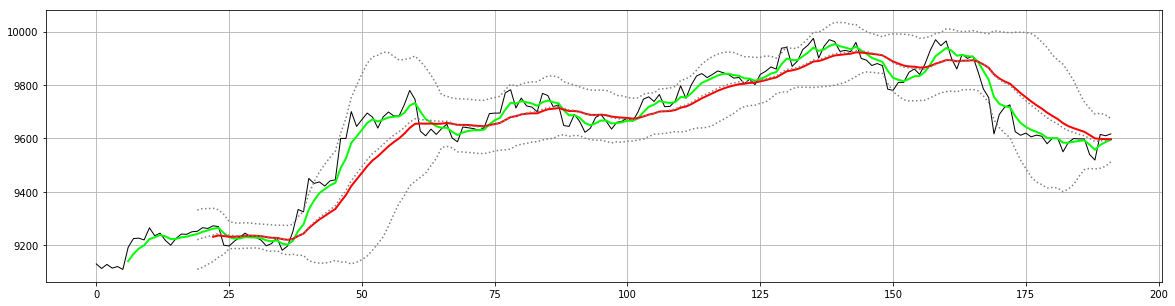

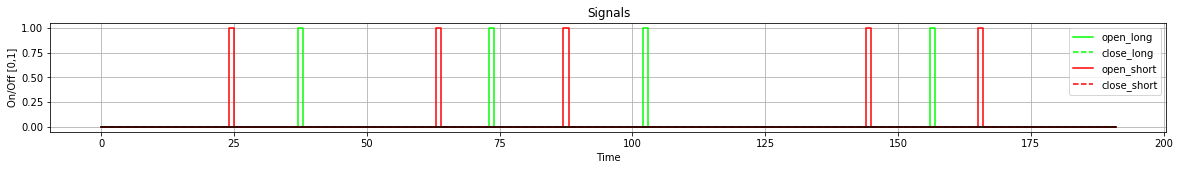

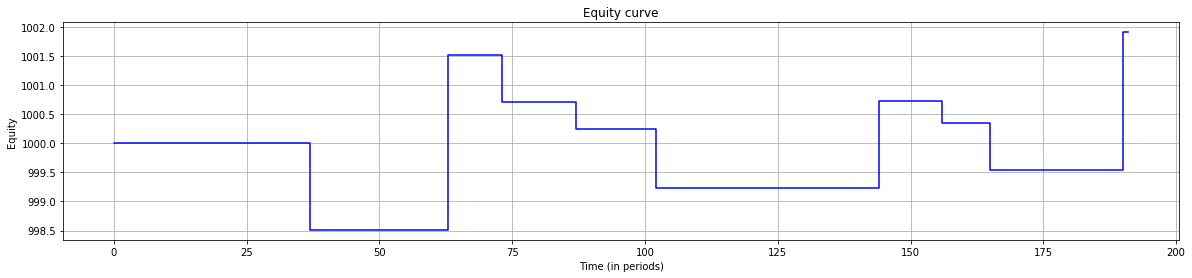

ROE %: 1.0019059730441768
Paid fees: 0.0


In [27]:
sim = TradingSim(chart)

sim.balance = 1000
sim.lot_size = 0.1
sim.fee_percentage = 0 #0.00075
sim.leverage = 1

sim.stop_loss = True
sim.stop_loss_type = 'none'
sim.stop_loss_percentage = 0.01

sim.run()
print('Final balance: {}'.format(sim.balance))

analysis = AnalyzeSim(sim)
analysis.summary()
analysis.chart().show()
analysis.signals().show()
analysis.equity_curve().show()

print('ROE %: {}'.format(analysis.roe()))
print('Paid fees: {}'.format(analysis.paid_fees()))

In [28]:
sim.trades_to_datatable()

,state,position_type,lot_size_base,lot_size_base_leveraged,lot_size_quote,lot_size_quote_leveraged,leverage,entry_price,exit_price,fee_percentage,stop_loss,stop_loss_percentage,stop_loss_price,order_cost,market_value,pl,pl_percent,paid_fees
0,closed,short,100.000000,100.000000,0.010873,0.010873,1,9197.000000,9333.900000,0,none,0.01,9288.970000,100.000000,101.488529,-1.488529,0.985333,0.0
1,closed,long,99.851147,99.851147,0.010698,0.010698,1,9333.900000,9615.000001,0,none,0.01,9240.561000,99.851147,102.858267,3.007120,1.030116,0.0
2,closed,short,100.151859,100.151859,0.010416,0.010416,1,9615.000001,9693.000000,0,none,0.01,9711.150001,100.151859,100.964323,-0.812464,0.991953,0.0
3,closed,long,100.070613,100.070613,0.010324,0.010324,1,9693.000000,9648.410000,0,none,0.01,9596.070000,100.070613,99.610265,-0.460348,0.995400,0.0
4,closed,short,100.024578,100.024578,0.010367,0.010367,1,9648.410000,9747.045000,0,none,0.01,9744.894100,100.024578,101.047122,-1.022544,0.989881,0.0
5,closed,long,99.922324,99.922324,0.010252,0.010252,1,9747.045000,9893.156569,0,none,0.01,9649.574550,99.922324,101.420194,1.497870,1.014990,0.0
6,closed,short,100.072111,100.072111,0.010115,0.010115,1,9893.156569,9930.046175,0,none,0.01,9992.088135,100.072111,100.445259,-0.373149,0.996285,0.0
7,closed,long,100.034796,100.034796,0.010074,0.010074,1,9930.046175,9850.000001,0,none,0.01,9830.745713,100.034796,99.228414,-0.806381,0.991939,0.0
8,closed,short,99.954158,99.954158,0.010148,0.010148,1,9850.000001,9617.000000,0,none,0.01,9948.500001,99.954158,97.589760,2.364398,1.024228,0.0
